# Сегментация

### Задача 
Попробуйте обучить нейронную сеть U-Net на любом другом датасете. Опишите в комментарии к уроку - какой результата вы добились от нейросети? Что помогло вам улучшить ее точность?

In [ ]:
import os
import skimage.io as io
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
MY_DRIVE_PATH = '/content/drive/My Drive/Colab Notebooks/Computer_vision/Models'

### Скачиваем датасет COCO и API для работы с ним

In [ ]:
%%time
if not os.path.isdir('data'):
    !mkdir -p data

    !cd data && wget http://images.cocodataset.org/zips/train2017.zip 
    !cd data && wget http://images.cocodataset.org/zips/val2017.zip 
    !cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip 

    !cd data && unzip -q train2017.zip
    !cd data && unzip -q val2017.zip
    !cd data && unzip -q annotations_trainval2017.zip

    !cd data && git clone https://github.com/cocodataset/cocoapi
    !cd data/cocoapi/PythonAPI && make

CPU times: user 278 µs, sys: 0 ns, total: 278 µs
Wall time: 217 µs


### Подготовка COCO API

In [ ]:
COCO_ROOT = 'data'
import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

### Универсальный класс Dataset для сегментации

In [ ]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, 4))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :4]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

### Класс для сегментационного датасета COCO
Класс наследутся от универсльного `Dataset` и реализует кастомную функцию чтения данных.

In [ ]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        self.sublist = sublist
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

In [ ]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

loading annotations into memory...
Done (t=16.18s)
creating index...
index created!
loading annotations into memory...
Done (t=2.41s)
creating index...
index created!


### Параметры обучения

In [ ]:
TRAIN_BATCH_SIZE = 16
TRAIN_EPOCHS = 5
VAL_BATCH_SIZE = 16
INPUT_SIZE = 256

### Создаем итераторы

In [ ]:
train_ds = COCO_dataset_train.train_dataset(
    TRAIN_BATCH_SIZE, 
    TRAIN_EPOCHS, 
    INPUT_SIZE)

val_ds = COCO_dataset_val.val_dataset(
    VAL_BATCH_SIZE, 
    INPUT_SIZE)

### Строим модель U-net

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(INPUT_SIZE, INPUT_SIZE, 3), 
    include_top=False
)

layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

layers = [base_model.get_layer(name).output for name in layer_names]

down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = True

up_stack = [
    tf.keras.layers.UpSampling2D(interpolation='bilinear'),  # 4x4 -> 8x8
    tf.keras.layers.UpSampling2D(interpolation='bilinear'),  # 8x8 -> 16x16
    tf.keras.layers.UpSampling2D(interpolation='bilinear'),  # 16x16 -> 32x32
    tf.keras.layers.UpSampling2D(interpolation='bilinear'),   # 32x32 -> 64x64
]

def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[INPUT_SIZE, INPUT_SIZE, 3])
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, 
        kernel_size=(3, 3), 
        strides=(2, 2),
        padding='same')  #128x128 -> 256x256
    x = last(x)
    out = tf.nn.sigmoid(x)

    return tf.keras.Model(inputs=inputs, outputs=out)

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
model = unet_model(1)
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

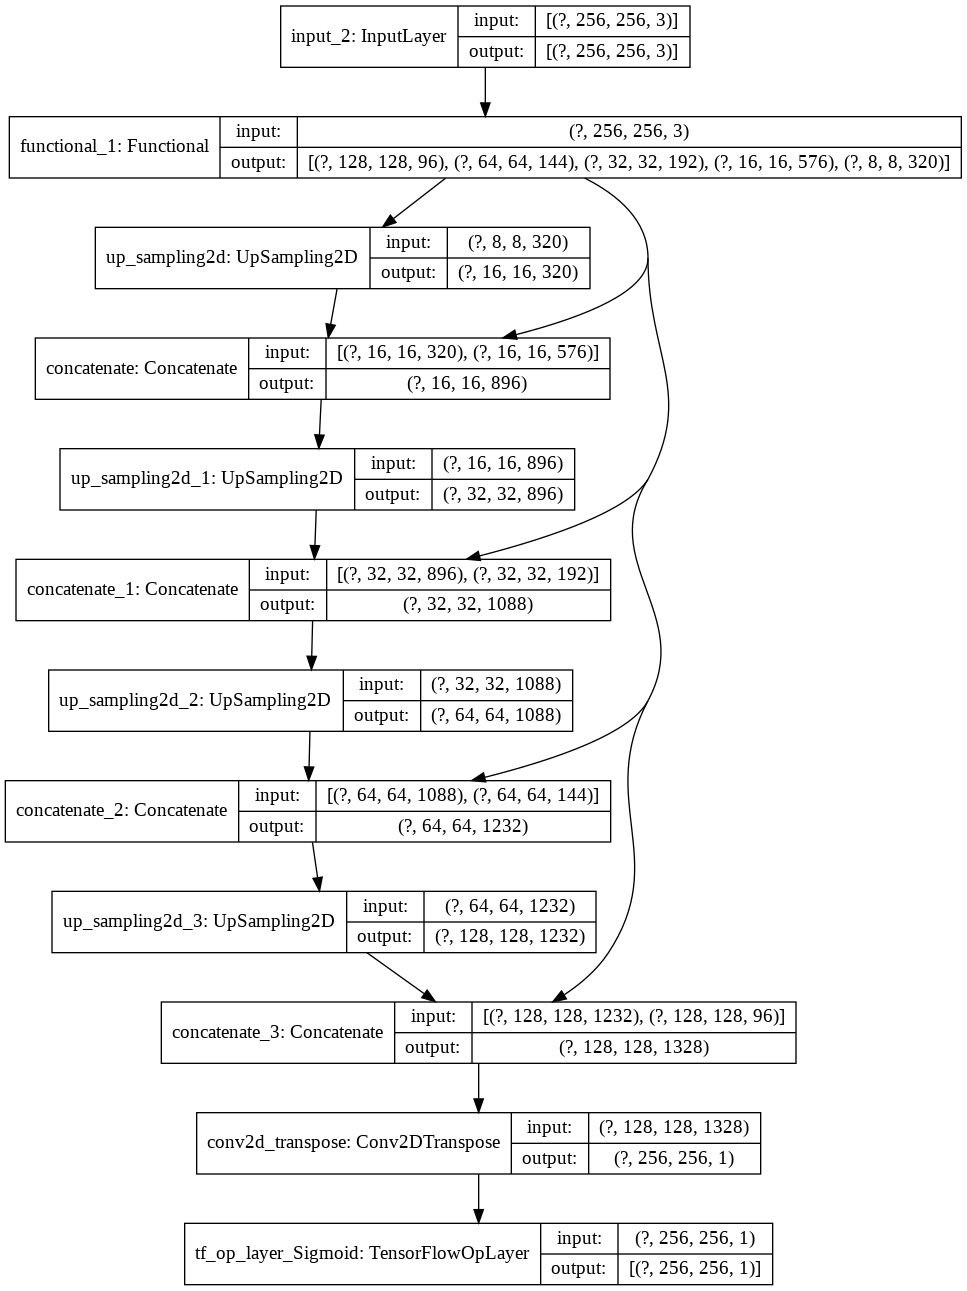

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Обучение

In [19]:
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(
        MY_DRIVE_PATH, 
        'coco_segm_loss{val_loss:.2f}_acc{val_accuracy:.2f}.hdf5'), 
    save_weights_only=True)

history = model.fit(
    train_ds,
    steps_per_epoch=len(COCO_dataset_train.img_list) // TRAIN_BATCH_SIZE,
    validation_data=val_ds,
    validation_steps=len(COCO_dataset_val.img_list) // VAL_BATCH_SIZE,
    epochs=TRAIN_EPOCHS,
    callbacks=[callback])

Epoch 1/5
4007/4007 [==============================] - 1995s 498ms/step - loss: 0.2302 - accuracy: 0.9025 - val_loss: 0.3360 - val_accuracy: 0.8518
Epoch 2/5
4007/4007 [==============================] - 1908s 476ms/step - loss: 0.1981 - accuracy: 0.9178 - val_loss: 0.2270 - val_accuracy: 0.9056
Epoch 3/5
4007/4007 [==============================] - 1843s 460ms/step - loss: 0.1867 - accuracy: 0.9225 - val_loss: 0.3354 - val_accuracy: 0.8594
Epoch 4/5
4007/4007 [==============================] - 1839s 459ms/step - loss: 0.1784 - accuracy: 0.9263 - val_loss: 0.1995 - val_accuracy: 0.9167
Epoch 5/5
4007/4007 [==============================] - 1831s 457ms/step - loss: 0.1733 - accuracy: 0.9286 - val_loss: 0.1995 - val_accuracy: 0.9195


### Запуск предсказания на нашем изображении

In [20]:
def img_inference(img_path, treshold=.5):
    img = plt.imread(img_path).astype(np.float32) / 255
    preds = model(np.array([img]))[0]
    seg_map = np.float32(preds[..., 0] > treshold)
    seg_map_clr = plt.get_cmap('viridis')(seg_map)[..., :3]

    fig = plt.figure(figsize=(19, 4))

    ax0 = plt.subplot(1, 3, 1)
    ax0.imshow(img)
    plt.xticks([]), plt.yticks([])

    ax1 = plt.subplot(1, 3, 3)
    heatmap = ax1.imshow(preds[..., 0])
    plt.xticks([]), plt.yticks([])
    fig.colorbar(heatmap, shrink=1)

    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(img * 0.5 + seg_map_clr * 0.5)
    plt.xticks([]), plt.yticks([])

    plt.show()

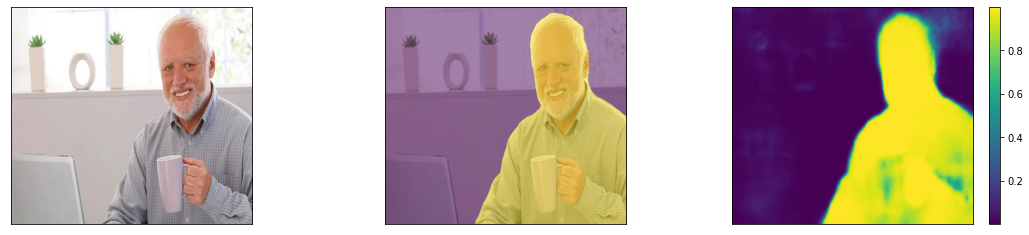

In [27]:
img_inference('harold2.jpg', treshold=0.5)